In [100]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import pylab as py
import scipy.stats as stats 
from scipy.stats import norm, skew, probplot
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from featurewiz import featurewiz

Imported featurewiz: advanced feature engg and selection library. Version=0.0.42
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [2]:
year = ['2011','2012','2013','2014','2015','2016','2017','2018']
data_ = pd.DataFrame()

acs = pd.read_csv("../data/ACS_2011.csv")
acs['year'] = 2011

pp = pd.read_csv("../data/ACS_2012.csv")
pp['year'] = 2012
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2013.csv")
pp['year'] = 2013
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2014.csv")
pp['year'] = 2014
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2015.csv")
pp['year'] = 2015
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2016.csv")
pp['year'] = 2016
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2017.csv")
pp['year'] = 2017
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2018.csv")
pp['year'] = 2018
data_ = acs.append(pp)

In [123]:
zir = pd.read_csv("../data/Zip_Zri_MultiFamilyResidenceRental.csv")

In [124]:
data_['geo_id'] = data_['geo_id'].astype(str).str.zfill(5)
zir['RegionName'] = zir['RegionName'].astype(str).str.zfill(5)

In [125]:
cols_replace = list(zir.columns)[7:]
cols_keep = list(zir.columns)[:7]
zil_new = zir.melt(id_vars=cols_keep, value_vars = cols_replace)
zil_new['variable']= pd.to_datetime(zil_new['variable'])

In [126]:
zil_new['year'] = zil_new['variable'].apply(lambda a: a.year)
zil_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210293 entries, 0 to 210292
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionID    210293 non-null  int64         
 1   RegionName  210293 non-null  object        
 2   City        210293 non-null  object        
 3   State       210293 non-null  object        
 4   Metro       209954 non-null  object        
 5   CountyName  210293 non-null  object        
 6   SizeRank    210293 non-null  int64         
 7   variable    210293 non-null  datetime64[ns]
 8   value       140035 non-null  float64       
 9   year        210293 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 16.0+ MB


In [127]:
zil_yr = zil_new.groupby(['RegionName', 'year']).mean().reset_index()
zil_yr.drop(['SizeRank','RegionID'], inplace=True, axis=1)

In [131]:
zil_targets = zil_yr[zil_yr['year'] > 2011]
zil_targets = zil_targets[zil_targets['year'] < 2020]
zil_targets.head(50)

,RegionName,year,value
2,01013,2012,943.416667
3,01013,2013,923.583333
4,01013,2014,936.083333
5,01013,2015,962.166667
6,01013,2016,1030.333333
7,01013,2017,1065.916667
8,01013,2018,1139.416667
9,01013,2019,1132.750000
13,01020,2012,937.166667
14,01020,2013,929.083333


In [120]:
zil_yr = zil_yr.dropna()
zil_targets = zil_yr[zil_yr['year'] > 2011]
zil_yr = zil_yr[zil_yr['year'] > 2010]
zil_yr = zil_yr[zil_yr['year'] < 2019]

In [10]:
df_final = zil_yr.merge(data_, how='left', left_on = ['RegionName','year'], right_on=['geo_id', 'year'])

In [11]:
df_final.drop(['pop_5_years_over', 'speak_only_english_at_home', 'speak_spanish_at_home_low_english', 
               'pop_15_and_over', 'pop_never_married', 'pop_now_married', 'pop_separated', 'pop_widowed',
              'pop_divorced', 'geoid','speak_spanish_at_home'], axis=1, inplace=True)

In [12]:
df_final[df_final['geo_id'].isnull()]

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,less_one_year_college,masters_degree,one_year_more_college,pop_25_years_over,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,do_date
2509,11249,2011,2349.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2510,11249,2012,2690.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2511,11249,2013,2953.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2512,11249,2014,2964.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2513,11249,2015,3015.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2514,11249,2016,3109.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2515,11249,2017,3066.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2516,11249,2018,2902.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7184,75033,2016,1372.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7185,75033,2017,1564.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_final = df_final[df_final['RegionName']!='11249']
df_final = df_final[df_final['RegionName']!='75033']

df_final[df_final['geo_id'].isnull()]

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,less_one_year_college,masters_degree,one_year_more_college,pop_25_years_over,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,do_date


In [14]:
null_zip = list(zip(df_final.columns, list(df_final.isnull().sum())))
non_zero = []
col_names = []
for i, j in null_zip:
    if j>0:
        non_zero.append(j)
        col_names.append(i)
list(zip(col_names, non_zero))

[('aggregate_travel_time_to_work', 28),
 ('owner_occupied_housing_units_lower_value_quartile', 3),
 ('owner_occupied_housing_units_median_value', 1),
 ('owner_occupied_housing_units_upper_value_quartile', 1),
 ('male_60_61', 1639),
 ('male_62_64', 1639),
 ('white_including_hispanic', 1639),
 ('black_including_hispanic', 1639),
 ('amerindian_including_hispanic', 1639),
 ('asian_including_hispanic', 1639),
 ('commute_5_9_mins', 1639),
 ('commute_35_39_mins', 1639),
 ('commute_40_44_mins', 1639),
 ('commute_60_89_mins', 1639),
 ('commute_90_more_mins', 1639),
 ('households_retirement_income', 1639),
 ('associates_degree', 874),
 ('bachelors_degree', 874),
 ('high_school_diploma', 874),
 ('less_one_year_college', 874),
 ('masters_degree', 874),
 ('one_year_more_college', 874),
 ('pop_25_years_over', 874)]

In [15]:
df_final[df_final[col_names].isnull().any(axis=1)][col_names]

df_final_sorted = df_final.sort_values(by=['RegionName', 'year'])

In [16]:
null_2011 = ['associates_degree', 'bachelors_degree', 
             'high_school_diploma', 
             'less_one_year_college', \
             'masters_degree', 
             'one_year_more_college', 
             'pop_25_years_over']

null_2018 = ['white_including_hispanic', 'black_including_hispanic', 
             'amerindian_including_hispanic', 
             'asian_including_hispanic', 
             'commute_5_9_mins', 'commute_35_39_mins', 
             'commute_40_44_mins', 'commute_60_89_mins', 
             'commute_90_more_mins', 'households_retirement_income',
            'male_60_61','male_62_64']

for i in range(0, df_final_sorted.shape[0]):
    if df_final_sorted['year'].iloc[i] == 2011:
        for j in range(0,len(null_2011)):
            df_final_sorted[null_2011[j]].iloc[i] = df_final_sorted[null_2011[j]].iloc[i+1]
    if df_final_sorted['year'].iloc[i] == 2018:
        for j in range(0,len(null_2018)):
            df_final_sorted[null_2018[j]].iloc[i] = df_final_sorted[null_2018[j]].iloc[i-1]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
df_final = df_final_sorted.loc[:, df_final_sorted.columns != 'do_date']
df_final = df_final.dropna()

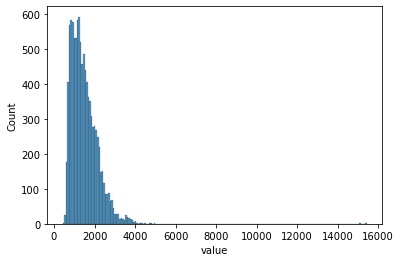

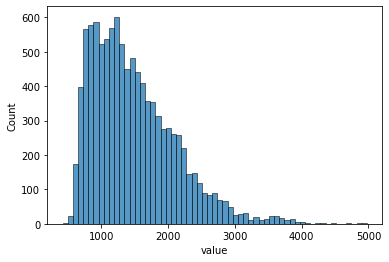

In [18]:
sns.histplot(x = 'value', data = df_final)
plt.show()
df_final = df_final[df_final['value'] < 6000]
sns.histplot(x = 'value', data = df_final)
plt.show()

In [19]:
# Filter Cityies with less than 100,000 people
zil_city = df_final.merge(zir, on = 'RegionName', how = 'left')
zil_city = zil_city[['RegionName','City','total_pop','year']]
zil_city = zil_city[zil_city['year'] == 2018]
zil_city.drop('year', inplace = True, axis= 1)
zil_city = zil_city.groupby('City').sum('total_pop').sort_values(by = 'total_pop')

zil_filter = zil_city[zil_city['total_pop'] >= 100000].reset_index()
zil_filter = zil_filter['City']

In [21]:
df_filtered = df_final.merge(zir[['RegionName','City']], on = 'RegionName', how = 'left')

df_filtered = df_filtered[df_filtered['City'].isin(zil_filter)]

## Cluster on three features

In [22]:
df_small_fil = df_filtered[['value', 'total_pop', 'median_income']]
df_small_fil

,value,total_pop,median_income
34,946.100000,22285.0,29184.0
35,972.583333,23485.0,28858.0
36,1058.666667,23183.0,28590.0
37,1129.166667,23635.0,30053.0
38,1125.083333,23876.0,31113.0
...,...,...,...
10246,979.000000,30237.0,39046.0
10247,995.833333,31010.0,39151.0
10248,1036.166667,30630.0,37982.0
10249,1154.833333,30313.0,39955.0


In [27]:
scaler = StandardScaler().fit(df_small_fil)
features = scaler.transform(df_small_fil)
df_scal = pd.DataFrame(features, columns = df_small_fil.columns)


In [30]:
columns = df_small_fil.columns
kmeans = KMeans(n_clusters = 3)
y = kmeans.fit_predict(df_small_fil[columns])
   
df_filtered['Cluster'] = y

## Add CPI data

In [31]:
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

cpi = [251.645, 257.081, 263.050, 270.509, 278.802, 288.233, 297.808, 307.660]
cpi_df = pd.DataFrame()
cpi_df['year'] = year
cpi_df['cpi'] = cpi
cpi_df

,year,cpi
0,2011,251.645
1,2012,257.081
2,2013,263.050
3,2014,270.509
4,2015,278.802
5,2016,288.233
6,2017,297.808
7,2018,307.660


In [39]:
df_addition = df_filtered.merge(cpi_df, how = 'left', on = 'year')

## Add GDP Growth (%) data

In [40]:
# Add GDP Growth (%)
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

gdp = [1.5508, 2.2495, 1.8421, 2.526, 3.0755, 1.7114, 2.3327, 2.9965]
gdp_df = pd.DataFrame()
gdp_df['year'] = year
gdp_df['gdp'] = gdp
gdp_df

,year,gdp
0,2011,1.5508
1,2012,2.2495
2,2013,1.8421
3,2014,2.5260
4,2015,3.0755
5,2016,1.7114
6,2017,2.3327
7,2018,2.9965


In [41]:
df_addition = df_addition.merge(gdp_df, how = 'left', on = 'year')

## Add Fed Interest Rate data

In [42]:
# Add Federal Interest Rate data
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

interest = [0.1016666667, 0.14, 0.1075, 0.08916666667, 0.1325, 0.395, 
            0.655, 1.42]
interest_df = pd.DataFrame()
interest_df['year'] = year
interest_df['interest'] = interest
interest_df

,year,interest
0,2011,0.101667
1,2012,0.140000
2,2013,0.107500
3,2014,0.089167
4,2015,0.132500
5,2016,0.395000
6,2017,0.655000
7,2018,1.420000


In [43]:
df_addition = df_addition.merge(interest_df, how = 'left', on = 'year')
df_addition

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,City,Cluster,cpi,gdp,interest
0,01104,2014,946.100000,01104,3346.0,5526.0,1949.0,158.0,1597.0,523.0,...,274.0,373.0,1215.0,8509.0,11849.0,Springfield,2,270.509,2.5260,0.089167
1,01104,2015,972.583333,01104,3377.0,5407.0,1948.0,146.0,1791.0,466.0,...,267.0,440.0,1582.0,9057.0,12909.0,Springfield,2,278.802,3.0755,0.132500
2,01104,2016,1058.666667,01104,3432.0,5434.0,1949.0,172.0,1898.0,516.0,...,291.0,418.0,1570.0,8844.0,13253.0,Springfield,2,288.233,1.7114,0.395000
3,01104,2017,1129.166667,01104,3287.0,5702.0,1946.0,107.0,2032.0,577.0,...,287.0,338.0,1635.0,8829.0,14100.0,Springfield,2,297.808,2.3327,0.655000
4,01104,2018,1125.083333,01104,3478.0,5599.0,1946.0,75.0,1963.0,502.0,...,271.0,364.0,1664.0,8918.0,14439.0,Springfield,2,307.660,2.9965,1.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,98499,2014,979.000000,98499,5610.0,6870.0,1973.0,265.0,2355.0,952.0,...,583.0,958.0,1375.0,12481.0,6395.0,Lakewood,2,270.509,2.5260,0.089167
6068,98499,2015,995.833333,98499,5736.0,6891.0,1973.0,346.0,2355.0,816.0,...,630.0,1105.0,1502.0,12735.0,6862.0,Lakewood,2,278.802,3.0755,0.132500
6069,98499,2016,1036.166667,98499,5670.0,6965.0,1973.0,310.0,2352.0,995.0,...,596.0,1285.0,1537.0,12984.0,6444.0,Lakewood,2,288.233,1.7114,0.395000
6070,98499,2017,1154.833333,98499,5149.0,7244.0,1973.0,327.0,2367.0,1006.0,...,611.0,1445.0,1400.0,12993.0,6260.0,Lakewood,2,297.808,2.3327,0.655000


## Add Census business data

In [44]:
bus_count = pd.read_csv('../data/bus_count.csv')

In [49]:
bus_count['zip'] = bus_count['zip'].astype(str).str.zfill(5)
bus_count

,zip,est,year
0,00501,2,2011
1,01001,436,2011
2,01002,558,2011
3,01003,16,2011
4,01004,19,2011
...,...,...,...
307187,99926,12,2018
307188,99928,5,2018
307189,99929,96,2018
307190,99950,16,2018


In [50]:
df_addition = df_addition.merge(bus_count, how = 'left', left_on = ['RegionName', 'year'], right_on = ['zip', 'year'])

# Feature Engineering

<AxesSubplot:>

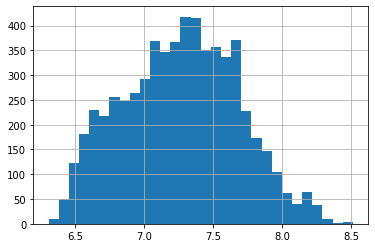

In [62]:
df_addition['log_value'] = np.log(df_addition['value'])
df_addition['log_value'].hist(bins=30)

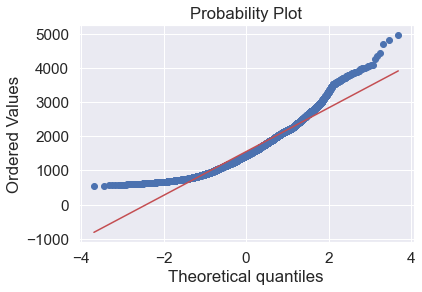

In [146]:
stats.probplot(df_addition['value'], dist="norm", plot=pylab)
pylab.show()

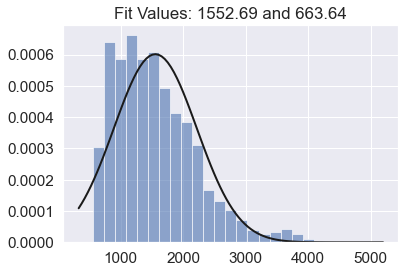

In [144]:
data_orig = df_addition['value']
mu, std = norm.fit(data_orig) 

# Plot the histogram.
plt.hist(data_orig, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

plt.show()

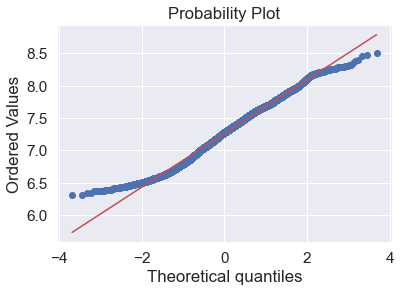

In [145]:
data = df_addition['log_value']
stats.probplot(data, dist="norm", plot=pylab)
pylab.show()

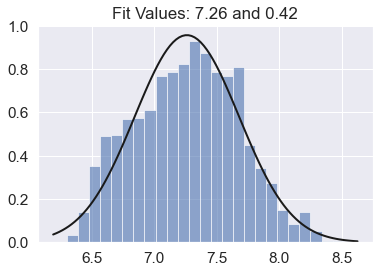

In [143]:
data = df_addition['log_value']
mu, std = norm.fit(data) 

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

plt.show()

In [85]:
df_addition.columns

Index(['RegionName', 'year', 'value', 'geo_id', 'nonfamily_households',
       'family_households', 'median_year_structure_built',
       'rent_burden_not_computed', 'rent_over_50_percent',
       'rent_40_to_50_percent',
       ...
       'commuters_16_over', 'hispanic_any_race', 'City', 'Cluster', 'cpi',
       'gdp', 'interest', 'zip', 'est', 'log_value'],
      dtype='object', length=252)

In [91]:
df_addition.select_dtypes(include=['object'])

,RegionName,geo_id,City,zip
0,01104,01104,Springfield,01104
1,01104,01104,Springfield,01104
2,01104,01104,Springfield,01104
3,01104,01104,Springfield,01104
4,01104,01104,Springfield,01104
...,...,...,...,...
6067,98499,98499,Lakewood,98499
6068,98499,98499,Lakewood,98499
6069,98499,98499,Lakewood,98499
6070,98499,98499,Lakewood,98499


In [87]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [95]:
pd.set_option('display.max_rows', None)
calc_vif(df_addition.select_dtypes(exclude=['object'])).sort_values(by='VIF')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
88,housing_built_2005_or_later,2.639106e+00
89,housing_built_2000_to_2004,2.945716e+00
186,female_female_households,4.448608e+00
90,housing_built_1939_or_earlier,5.339577e+00
34,vacant_housing_units_for_sale,5.340851e+00
38,million_dollar_housing_units,5.638190e+00
207,male_male_households,6.105928e+00
246,est,8.378636e+00
139,amerindian_including_hispanic,8.756355e+00
33,vacant_housing_units_for_rent,1.055058e+01


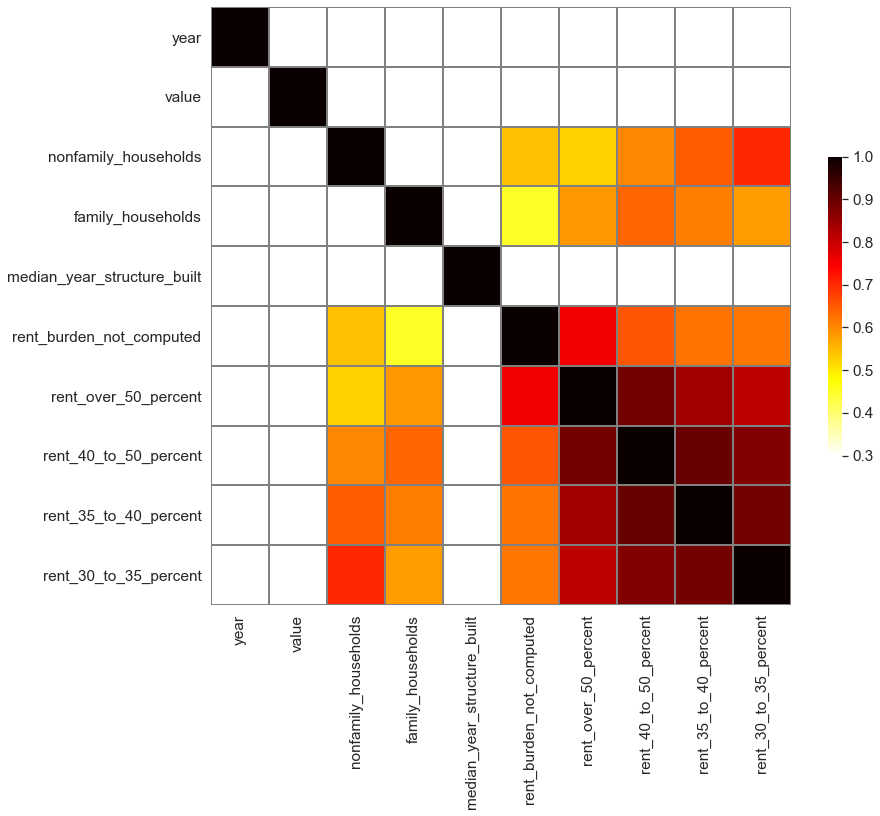

In [97]:
from copy import copy


corr = df_addition.select_dtypes(exclude=['object']).iloc[:,0:10].corr()
corr = abs(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

#conditions for filtering 0.6<=r<=0.9
sns.set(font_scale=1.4)

cmap =  copy(plt.cm.hot_r)
cmap.set_over("white")
cmap.set_under("white")


with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(13,11))
    sns.heatmap(abs(corr),
                vmax = 1,
                vmin = 0.3,
                cmap = cmap,
                cbar_kws = {'shrink':.5},
                linewidth = 1,
               linecolor = "grey");



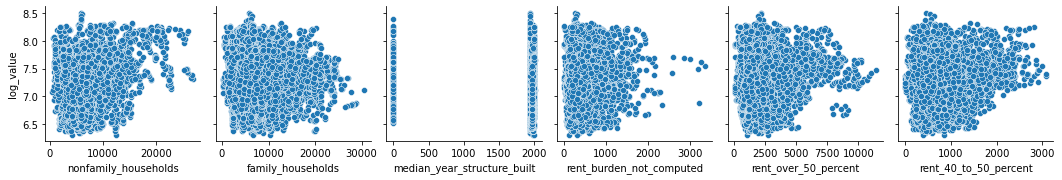

In [78]:
sns.pairplot(data = df_addition, y_vars = ['log_value'], x_vars = df_addition.iloc[:,4:10])

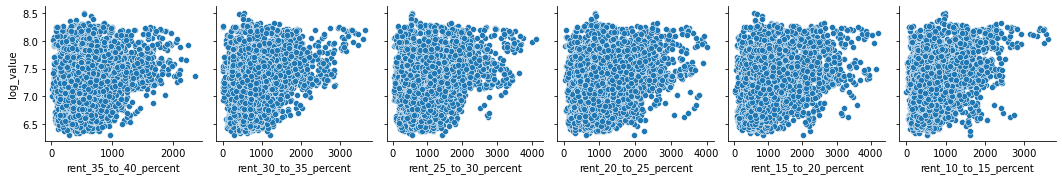

In [81]:
sns.pairplot(data = df_addition, y_vars = ['log_value'], x_vars = df_addition.iloc[:,10:16])

# Automatic Feature Selection using Featurewiz

In [132]:
zil_targets['year'] = zil_targets['year'] - 1
zil_targets.head(50)

,RegionName,year,value
2,01013,2011,943.416667
3,01013,2012,923.583333
4,01013,2013,936.083333
5,01013,2014,962.166667
6,01013,2015,1030.333333
7,01013,2016,1065.916667
8,01013,2017,1139.416667
9,01013,2018,1132.750000
13,01020,2011,937.166667
14,01020,2012,929.083333


In [133]:
zil_targets['future_value'] = zil_targets['value']
zil_targets.drop('value', axis=1, inplace=True)
zil_targets.head(10)

,RegionName,year,future_value
2,01013,2011,943.416667
3,01013,2012,923.583333
4,01013,2013,936.083333
5,01013,2014,962.166667
6,01013,2015,1030.333333
7,01013,2016,1065.916667
8,01013,2017,1139.416667
9,01013,2018,1132.750000
13,01020,2011,937.166667
14,01020,2012,929.083333


In [134]:
target = df_addition.merge(zil_targets, on = ['RegionName','year'], how='left')
target.head(10)

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,hispanic_any_race,City,Cluster,cpi,gdp,interest,zip,est,log_value,future_value
0,01104,2014,946.100000,01104,3346.0,5526.0,1949.0,158.0,1597.0,523.0,...,11849.0,Springfield,2,270.509,2.5260,0.089167,01104,525,6.852348,972.583333
1,01104,2015,972.583333,01104,3377.0,5407.0,1948.0,146.0,1791.0,466.0,...,12909.0,Springfield,2,278.802,3.0755,0.132500,01104,515,6.879956,1058.666667
2,01104,2016,1058.666667,01104,3432.0,5434.0,1949.0,172.0,1898.0,516.0,...,13253.0,Springfield,2,288.233,1.7114,0.395000,01104,531,6.964766,1129.166667
3,01104,2017,1129.166667,01104,3287.0,5702.0,1946.0,107.0,2032.0,577.0,...,14100.0,Springfield,2,297.808,2.3327,0.655000,01104,534,7.029235,1125.083333
4,01104,2018,1125.083333,01104,3478.0,5599.0,1946.0,75.0,1963.0,502.0,...,14439.0,Springfield,2,307.660,2.9965,1.420000,01104,508,7.025612,1145.583333
5,01108,2011,1127.545455,01108,3089.0,6066.0,1939.0,167.0,1907.0,439.0,...,9048.0,Springfield,2,251.645,1.5508,0.101667,01108,269,7.027798,1025.909091
6,01108,2012,1025.909091,01108,3003.0,6125.0,1939.0,176.0,1971.0,457.0,...,9821.0,Springfield,2,257.081,2.2495,0.140000,01108,262,6.933334,1033.583333
7,01108,2013,1033.583333,01108,3152.0,6196.0,1939.0,332.0,2265.0,393.0,...,9981.0,Springfield,2,263.050,1.8421,0.107500,01108,271,6.940787,1005.909091
8,01108,2014,1005.909091,01108,3070.0,6550.0,1939.0,314.0,2349.0,355.0,...,11069.0,Springfield,2,270.509,2.5260,0.089167,01108,264,6.913647,1011.250000
9,01108,2015,1011.250000,01108,3101.0,6615.0,1939.0,348.0,2320.0,517.0,...,11673.0,Springfield,2,278.802,3.0755,0.132500,01108,270,6.918942,1095.083333


In [152]:
target = target.dropna()

In [166]:
train = target[target['year'] < 2018]
test = target[target['year'] == 2018]

In [167]:
train_feat = train.drop('future_value', axis=1)

In [168]:
test_feat = test.drop('future_value', axis=1)

In [169]:
test_feat = test_feat.drop('value', axis=1)
train_feat = train_feat.drop('value', axis=1)

In [170]:
Y_train = np.log(train[['future_value']])
X_train = train_feat.select_dtypes(exclude=['object'])

In [171]:
Y_test = np.log(test[['future_value']])
X_test = test_feat.select_dtypes(exclude=['object'])

# TEST LASSO REGRESSION 

In [172]:
scaler = StandardScaler().fit(X_train)
features = scaler.transform(X_train)
X_std = pd.DataFrame(features, columns = X_train.columns)

In [173]:
alphas = 10**np.linspace(10,-2,500)*0.5

lassocv = LassoCV(alphas = alphas, random_state=0)
lassocv.fit(X_std, Y_train)
lassocv_alpha = lassocv.alpha_

In [174]:
las = Lasso(alpha = lassocv.alpha_, random_state = 0)
las.fit(X_std,Y_train)

Lasso(alpha=0.005, random_state=0)

In [189]:
print('Score for training data:', las.score(X_std,Y_train))

pred = las.predict(X_std)
pred_unlog = np.exp(pred)
Y_unlog = np.exp(Y_train)
train_RMSE = mean_squared_error(Y_unlog, pred_unlog, squared = False)
print('(not log) RMSE for training data is:', train_RMSE)

Score for training data: 0.987960639106306
(not log) RMSE for training data is: 76.62442028783255


In [177]:
test_features = scaler.transform(X_test)
X_test_std = pd.DataFrame(test_features, columns = X_test.columns)

In [190]:
print('Score for test data:', las.score(X_test_std,Y_test))

pred_test = las.predict(X_test_std)
pred_test_unlog = np.exp(pred_test)
Y_test_unlog = np.exp(Y_test)
Test_RMSE = mean_squared_error(Y_test_unlog, pred_test_unlog, squared = False)
print('(not log) RMSE for test data is:', Test_RMSE)

Score for test data: 0.9869143734970762
(not log) RMSE for test data is: 83.50060296171225


In [181]:
las_imp = pd.DataFrame()

las_imp['Feature'] = X_test_std.columns
las_imp['Importance'] = list(las.coef_)
las_imp['Abs Importance'] = abs(las_imp['Importance'])
las_imp = las_imp.sort_values(by = 'Abs Importance', ascending = False)
las_imp



ranking = list(range(1,las_imp.shape[0]+1))
las_imp['ranking'] = ranking
las_imp

,Feature,Importance,Abs Importance,ranking
246,log_value,0.409718,0.409718,1
244,interest,-0.008157,0.008157,2
72,owner_occupied_housing_units_lower_value_quartile,0.003137,0.003137,3
243,gdp,0.002231,0.002231,4
31,vacant_housing_units,-0.000555,0.000555,5
128,female_60_to_61,0.000000,0.000000,6
170,different_house_year_ago_different_city,0.000000,0.000000,7
158,hispanic_male_55_64,0.000000,0.000000,8
159,white_male_45_54,0.000000,0.000000,9
160,white_male_55_64,0.000000,0.000000,10


In [182]:
X1_train = X_train.drop('log_value', axis=1)
X1_test = X_test.drop('log_value', axis=1)

In [184]:
X1_train = X1_train.drop('median_rent', axis=1)
X1_test = X1_test.drop('median_rent', axis=1)

In [188]:
# Run without previous rent values

scaler = StandardScaler().fit(X1_train)
features = scaler.transform(X1_train)
X1_std = pd.DataFrame(features, columns = X1_train.columns)

alphas = 10**np.linspace(10,-2,500)*0.5

lassocv1 = LassoCV(alphas = alphas, random_state=0)
lassocv1.fit(X1_std, Y_train)
lassocv1_alpha = lassocv1.alpha_

las1 = Lasso(alpha = lassocv1.alpha_, random_state = 0)
las1.fit(X1_std,Y_train)

print('Score for training data:', las1.score(X1_std,Y_train))

pred1 = las1.predict(X1_std)
pred2 = np.exp(pred1)
Y_train2 = np.exp(Y_train)
train_RMSE1 = mean_squared_error(Y_train2, pred2, squared = False)
print('(not log) RMSE for training data is:', train_RMSE1)

test_features1 = scaler.transform(X1_test)
X1_test_std = pd.DataFrame(test_features1, columns = X1_test.columns)

print('Score for test data:', las1.score(X1_test_std,Y_test))

pred_test1 = las1.predict(X1_test_std)
pred_test2 = np.exp(pred_test1)
Y_test2 = np.exp(Y_test)
Test_RMSE1 = mean_squared_error(Y_test2, pred_test2, squared = False)
print('(not log) RMSE for test data is:', Test_RMSE1)

las_imp1 = pd.DataFrame()

las_imp1['Feature'] = X1_test_std.columns
las_imp1['Importance'] = list(las1.coef_)
las_imp1['Abs Importance'] = abs(las_imp1['Importance'])
las_imp1 = las_imp1.sort_values(by = 'Abs Importance', ascending = False)
las_imp1



ranking1 = list(range(1,las_imp1.shape[0]+1))
las_imp1['ranking'] = ranking1
las_imp1

Score for training data: 0.8460346976862141
(not log) RMSE for training data is: 302.1030174452858
Score for test data: 0.8341241563350946
(not log) RMSE for test data is: 378.05046883354026


,Feature,Importance,Abs Importance,ranking
70,renter_occupied_housing_units_paying_cash_medi...,0.157445,0.157445,1
71,owner_occupied_housing_units_lower_value_quartile,0.115320,0.115320,2
77,dwellings_1_units_detached,-0.050401,0.050401,3
200,male_45_64_less_than_9_grade,0.049718,0.049718,4
170,different_house_year_ago_same_city,-0.043159,0.043159,5
51,commute_30_34_mins,0.040255,0.040255,6
159,white_male_55_64,-0.037195,0.037195,7
186,gini_index,0.035976,0.035976,8
0,year,0.035495,0.035495,9
79,dwellings_2_units,-0.035333,0.035333,10


## Break data into the different Clusters

In [ ]:
cluster1 = df_addition[df_addition['Cluster'] == 0]
print('Size of Cluster 1', cluster1.shape)

cluster2 = df_addition[df_addition['Cluster'] == 1]
print('Size of Cluster 2', cluster2.shape)

cluster3 = df_addition[df_addition['Cluster'] == 2]
print('Size of Cluster 3', cluster3.shape)

nocluster = df_addition
print('Size of all Data', nocluster.shape)

In [ ]:
# # Things to discuss:
#     Further feature engineering
#     Multicolinearity
#     Drop columns from lasso
#     Currently predicting 2019 values but if we want to predict 2021, we need to change target values by 2 years
#     Next steps: rerun with clusters and compare RSME
#     Compare PCA to Lasso selection
    